# Lab 2: Basics of Deep Learning

Before we start coding, please ensure that your PC has the following installed:

- Jupyter Notebook

- PyTorch

- pandas

---

In [1]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## What is MLP
**Multilayer Perceptron (MLP)** is a type of neural network composed of layers of connected neurons that can learn patterns in data for tasks such as classification or prediction. 

It consists of:
- An input layer
- One or more hidden layers
- An output layer

Each layer is fully connected to the next, and the network follows a feedforward architecture, meaning data flows in one direction from input to output, without loops or cycles.

MLPs are particularly effective for tasks involving:
- Pattern recognition
- Classification
- Regression
- Prediction

They are also commonly referred to as **feedforward neural networks (NN)**.

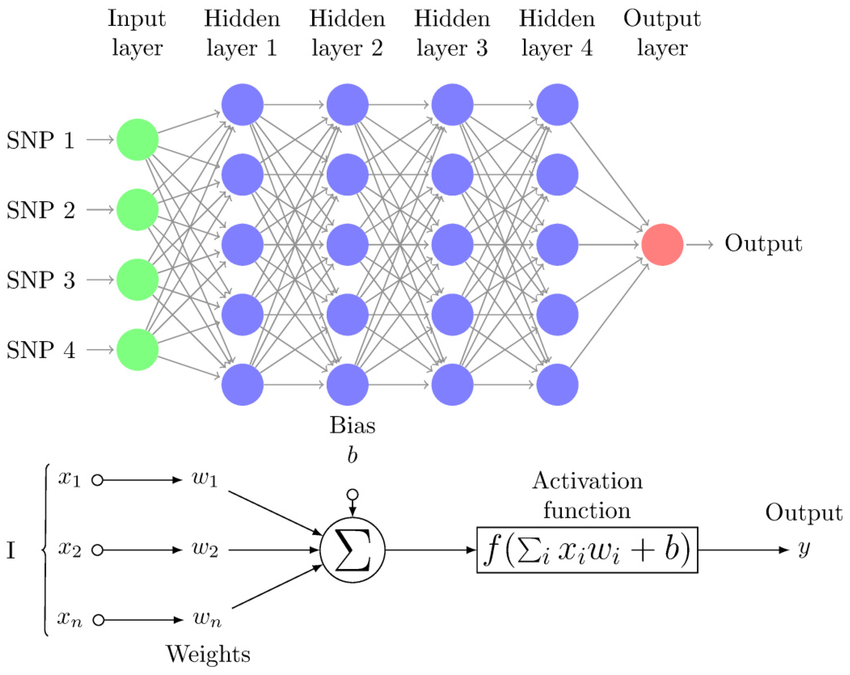

Real-World Applications of MLPs:
- Music Recommendation Systems
- Traffic Sign Recognition in Self-driving Cars
- Facial Recognition in Smartphones
  
and more ...


## Implementing an MLP using nn.Module
In this lab, we’ll build a simple MLP from scratch using PyTorch’s `nn.Module` and `nn.Linear` layers. This is the foundational step before we move on to training, validation, and evaluation.

### What is nn.Module?
[torch.nn.Module](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html) is the base class for all neural network modules in PyTorch. 

It allows you to:
- Define layers and parameters in the `__init__` method
- Specify the forward computation in the `forward` method

**Model Structure for Iris Species**

| Layer             | Input Size        | Output Size | Activation |
|------------------|-------------------|-------------|------------|
| Input Layer      | 5 | —         | —          |
| Linear Layer 1   | 5        | 128         | ReLU       |
| Linear Layer 2   | 128               | 64          | ReLU       |
| Output Layer     | 64                | 3           | — (raw logits) |


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a Multi-Layer Perceptron (MLP) using nn.Module
class IrisMLP(nn.Module):
    def __init__(self):
        super(IrisMLP, self).__init__()
        # Sequential model with 3 hidden layers and 1 output layer
        self.model = nn.Sequential(
            nn.Linear(5, 128),   # Input layer: 5 features → 128 neurons
            nn.ReLU(),           # Activation function: ReLU adds non-linearity
            nn.Linear(128, 64),  # Hidden layer: 128 → 64 neurons
            nn.ReLU(),
            nn.Linear(64, 3),   # Output layer: 64 → 3 classes (Setosa, Versicolor, Virginica)
        )

    def forward(self, x):
        # Forward pass: input x flows through the model
        return self.model(x)

model = IrisMLP()

# Move to GPU if available
if torch.cuda.is_available():
  model = model.cuda()
    
print(model)

IrisMLP(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=3, bias=True)
  )
)


>`nn.Sequential` is a PyTorch container that lets you stack layers or operations in order, so the input flows through them one after another automatically.

>`nn.Linear` layers apply learned weights and biases to transform the data. 

The model takes a **1D array of structured features** (e.g., 4 features from the Iris dataset: sepal length, sepal width, petal length, and petal width), and passes it through layers of a neural network. Each layer transforms the data, and `nn.ReLU()` (Rectified Linear Unit) introduces non-linearity, helping the model learn complex relationships—like how petal dimensions might distinguish Setosa from Virginica.

While `nn.Linear` and `nn.ReLU` are staples in models for tabular data like Iris, PyTorch offers other layers that can enhance performance:

- `nn.BatchNorm1d` can help stabilize training by normalizing feature distributions across batches.

- `nn.Dropout` can reduce overfitting by randomly zeroing out parts of the input during training.

- `nn.Conv2d` is designed for image data and not typically useful for structured datasets like Iris.

## Train the MLP
This section focuses on training our MLP model using the [Iris Species](https://www.kaggle.com/datasets/uciml/iris?resource=download) data previously used in Lab 1.

We first load the Iris dataset using `pandas`.

In [3]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

iris_dataset = pd.read_csv("Iris.csv")

Since we only have one dataset for Iris species, we will shuffle the data and split it into two sets: **80%** for training and **20%** for validation.

In [4]:
# Shuffle the dataset to ensure random distribution
iris_dataset = iris_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Define the split ratio
train_frac = 0.8  # 80% training, 20% testing
split_idx = int(len(iris_dataset) * train_frac)

# Split into training and validation sets
train = iris_dataset[:split_idx]
test = iris_dataset[split_idx:]

We create a custom PyTorch `Dataset` class called `IrisDataset` to wrap our training and testing data.

In [5]:
class IrisDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.copy()
        self.feature_names = self.data.columns[:-1].tolist()
        self.label_map = {
            0: "Iris-setosa",
            1: "Iris-versicolor",
            2: "Iris-virginica"
        }
        self.data['Species'] = self.data['Species'].map({
            "Iris-setosa": 0,
            "Iris-versicolor": 1,
            "Iris-virginica": 2
        })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        features = torch.tensor(row.iloc[:-1].values, dtype=torch.float32)
        label = int(row.iloc[-1])
        return features, label


iris_train = IrisDataset(train)
iris_test = IrisDataset(test)

And wrap the dataset with `DataLoader`

In [6]:
train_loader = DataLoader(iris_train, batch_size=32, shuffle=True)
test_loader = DataLoader(iris_test, batch_size=32, shuffle=False)

Then we will define a Loss function and Optimizer for our model.

### **Loss functions**
There are three common loss functions that can be applied when training a model:

1. [`nn.L1Loss`](https://docs.pytorch.org/docs/stable/generated/torch.nn.L1Loss.html):

   Measures the mean absolute error between predicted and target values. Often used in regression tasks, especially when outliers are important. Related to L1 regularization.
   

2. [`nn.MSELoss`](https://docs.pytorch.org/docs/stable/generated/torch.nn.MSELoss.html):

    Measures the mean squared error between predicted and target values. Penalizes larger errors more than L1 and is commonly used in regression. Related to L2 regularization.
   

3. [`nn.CrossEntropyLoss`](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html):
    
   Combines `nn.LogSoftmax` and `nn.NLLLoss` in one; used for multi-class classification problems.

We chose `nn.CrossEntropyLoss` as the loss function and `SGD` as the optimizer for our model, since we are working on a multi-class classification task using tabular data from the Iris dataset.

In [7]:
loss_function = nn.CrossEntropyLoss()

if torch.cuda.is_available():
  loss_function = loss_function.cuda() #Move loss function to GPU

optimizer = optim.SGD(model.parameters(), lr=1e-3) #1e-3 = 0.001

Install the `tqdm` library to enable progress bar visualization

In [8]:
!pip install tqdm

With the MLP model, loss function, and optimizer defined, we can begin training using this loop:

In [9]:
from tqdm import tqdm # for making progress bar

epochs_num = 1 #unit of training progress

for epoch in range(epochs_num):
    model.train() # put model in training mode
    train_loop = tqdm(train_loader, position=0, leave=True)

    for (input, label) in train_loop:
        #move to GPU if CUDA is available in your devices
        if torch.cuda.is_available():
            input, label = input.cuda(), label.cuda()
        optimizer.zero_grad()         # set gradients to zero
        output = model(input) # feed input into the model
        loss = loss_function(output, label) # compute the loss between input and target
        loss.backward()               # compute the gradients
        optimizer.step()              # update model parameters with optimizer

        train_loop.set_description(f"Epoch [{epoch+1}/{epochs_num}]") #update progress bar when epoch is currently running
        train_loop.set_postfix(loss=loss.item()) #show the loss value of each epoch

Epoch [1/1]: 100%|██████████| 4/4 [00:00<00:00, 21.77it/s, loss=0.959]


> `optimizer.zero_grad()` will clears old gradients from the previous step. Otherwise, gradients would accumulate.

> `optimizer.step()` will updates the model’s weights using the gradients and the optimizer

## Incorporating validation during training
In the process of training a machine learning model, it is essential not only to optimize performance on the training data but also to assess how well the model generalizes to unseen data. This is achieved through validation.

**Purpose of Validation**

Validation serves as a critical checkpoint during training. 

It allows us to:

- `Evaluate generalization`: Measure the model’s performance on data it has not encountered during training.

- `Monitor progress`: Track accuracy and other metrics across epochs to assess learning trends.

- `Detect overfitting`: Identify when the model begins to memorize training data rather than learning general patterns.

By incorporating a validation phase after each training epoch, we gain insight into the model’s true effectiveness and can make informed decisions about training duration, model architecture, and hyperparameters.

### Implementing Validation

We can add a validation loop inside the training loop to evaluate the model’s performance during training. In the validation phase, the following steps are typically performed:

1. **Set the model to evaluation mode** with `model.eval()` to disable behaviors like dropout and batch normalization updates
2. **Disable gradient computation** using `torch.no_grad()` to reduce memory usage and improve efficiency
3. **Run the model on a separate validation dataset** and we use `test_loader` as validation dataset
4. **Compare the model’s predictions to the true labels** to compute accuracy or other relevant metrics.

You may adjust the number of training epochs by modifying the `epochs_num` variable or re-running the training process. It will allow you to observe how the model’s accuracy evolves over time.

In [10]:
#Training Part
epochs_num = 1 

for epoch in range(epochs_num):
    model.train() 
    train_loop = tqdm(train_loader, position=0, leave=True)

    for (input, label) in train_loop:
        if torch.cuda.is_available():
            input, label = input.cuda(), label.cuda()
        optimizer.zero_grad()         
        output = model.forward(input) 
        loss = loss_function(output, label)
        loss.backward()               
        optimizer.step()              

        train_loop.set_description(f"Epoch [{epoch+1}/{epochs_num}]") 
        train_loop.set_postfix(loss=loss.item()) 

#Validation Phase
    correct = 0
    total = 0
    
    model.eval()  # Set model to evaluation mode
    val_loop = tqdm(test_loader, desc="Validating", position=0, leave=True)
    
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in val_loop:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
    
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1) # Get predicted class labels
    
            total += labels.size(0) # Count total samples
            correct += (predicted == labels).sum().item() # Count correct predictions
    
            val_loop.set_postfix(acc=(100 * correct / total))  # Show accuracy

Validating: 100%|██████████| 1/1 [00:00<00:00, 32.47it/s, acc=43.3]


> In Python, the underscore `_` is a convention used to indicate that a particular value is being intentionally ignored.

In `_, predicted = torch.max(outputs.data, 1)`, `torch.max()` returns both the maximum values and their indices. Since we only need the predicted class indices, we use `_` to ignore the values and store the indices in predicted.

## Monitoring training using TensorBoard
[TensorBoard](https://docs.pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html#using-tensorboard-in-pytorch) is a powerful visualization tool that helps monitor and debug machine learning workflows. 

It allows you to:
- Track and visualize metrics such as loss and accuracy
- Visualize the model graph
- View histograms of weights and activations
- Display images, embeddings
- and more ...

To use TensorBoard during training, you’ll need to install `TensorFlow` (which includes the `TensorBoard` package):

In [11]:
!pip install tensorflow 

To verify that TensorFlow is installed and check its version, run the following code:

This will print the installed TensorFlow version, which is useful for ensuring compatibility with TensorBoard and other tools.

In [12]:
import tensorflow as tf
print(tf.__version__)

2.19.0


To monitor training progress in real time, we can log metrics such as loss and accuracy using **TensorBoard**. In PyTorch, this is done using the `SummaryWriter` class from `torch.utils.tensorboard`.

Before logging anything, we need to create a `SummaryWriter` instance:

In [13]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

### Logging Metrics with SummaryWriter
We can log values at different points in the training loop using the `SummaryWriter`. This allows us to track and visualize training progress in TensorBoard.

Common [`SummaryWriter`](https://docs.pytorch.org/docs/stable//tensorboard.html) Operations:
- `add_scalar()`: Logs a single scalar value (e.g., training loss, validation accuracy)
- `add_scalars()`: Logs multiple related scalar values under a shared tag (e.g., comparing multiple models or metrics)
- `add_image()`: Logs an image or a batch of images (useful for visualizing inputs, predictions, or filters)
- `add_images()`: Logs a grid of images (e.g., a batch of input samples)
- `add_histogram()`: Logs a histogram of tensor values (e.g., weights, gradients, or activations)
- `add_graph()`: Visualizes the model architecture and its computation graph
- `add_text()`:	Logs arbitrary text (e.g., notes, hyperparameters, or summaries)
- `add_embedding()`: Visualizes high-dimensional data like word embeddings or feature vectors using PCA or t-SNE
- `add_audio()`: Logs audio waveforms (useful for speech or sound-based models)
- `add_figure()`: Logs a custom matplotlib figure (e.g., confusion matrix or custom plots)


We use `add_scalar()` to track metrics like loss and accuracy at different stages of training:
- `writer.add_scalar("Loss/Train_Step", loss.item(), epoch * len(train_loader) + step)`
- `writer.add_scalar("Loss/Train_Epoch", avg_loss, epoch)`
- `writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)`

These logs will appear in TensorBoard and help you monitor how your model is learning over time.

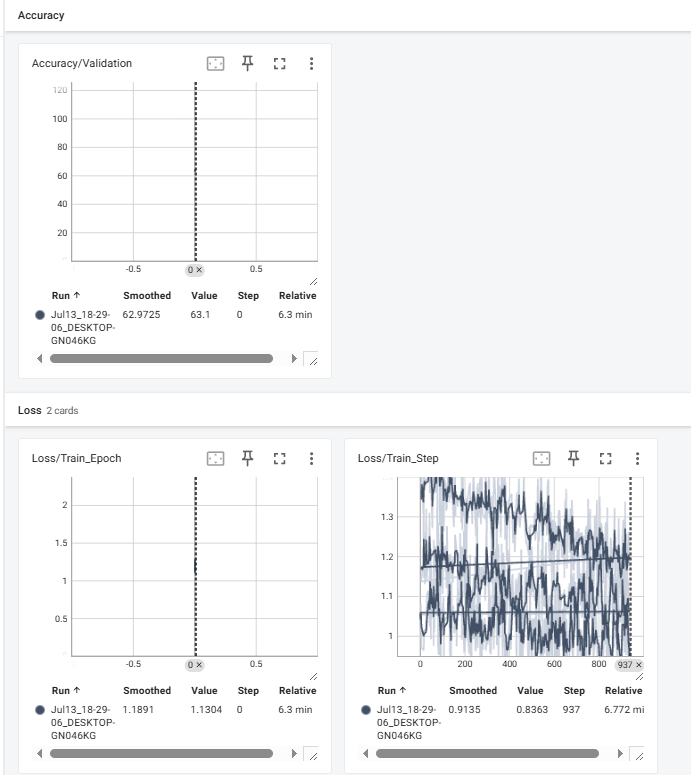

In [14]:
epochs_num = 1

for epoch in range(epochs_num):
    model.train() 
    train_loop = tqdm(train_loader, position=0, leave=True)

    #Data that want to Log:
    step = 0
    running_loss = 0.0
    avg_loss = 0.0
    val_accuracy = 0.0
    
    for (input, label) in train_loop: 
        if torch.cuda.is_available():
            input, label = input.cuda(), label.cuda()
        optimizer.zero_grad()         
        output = model.forward(input) 
        loss = loss_function(output, label) 
        loss.backward()               
        optimizer.step()         
        
        running_loss += loss.item()
        
        train_loop.set_description(f"Epoch [{epoch+1}/{epochs_num}]") 
        train_loop.set_postfix(loss=loss.item()) 

        #Log training loss per step
        writer.add_scalar("Loss/Train_Step", loss.item(), epoch * len(train_loader) + step)
        step += 1
        
    #Log average training loss per epoch
    avg_loss = running_loss / len(train_loader)
    writer.add_scalar("Loss/Train_Epoch", avg_loss, epoch)
    
    correct = 0
    total = 0
    
    model.eval() 
    val_loop = tqdm(test_loader, desc="Validating", position=0, leave=True)
    
    with torch.no_grad():  
        for inputs, labels in val_loop:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
    
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
    
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
            val_loop.set_postfix(acc=(100 * correct / total))  

    #Log validation accuracy per epoch
    val_accuracy = 100 * correct / total
    writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)

    writer.flush()

writer.close()

Validating: 100%|██████████| 1/1 [00:00<00:00, 183.03it/s, acc=43.3]


### Launching TensorBoard
To view your training logs in TensorBoard, run the following command:

In [15]:
!tensorboard --logdir=runs --port=6006

2025-08-10 14:21:53.563059: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-10 14:21:54.221957: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
E0810 14:21:56.230129 22900 program.py:300] TensorBoard could not bind to port 6006, it was already in use
ERROR: TensorBoard could not bind to port 6006, it was already in use


Once it's running, open your browser and go to [http://localhost:6006/](http://localhost:6006/) to explore the TensorBoard dashboard.

If TensorBoard keeps running in the background, you can stop it by clicking the `Stop button ■` in Jupyter Notebook.

> Tip: The `--logdir=runs` argument should match the directory where your `SummaryWriter` is saving logs. By default, it's `runs/`.

### Run TensorBoard from terminal/console
1. Open your terminal or command prompt
2. Install TensorBoard (*if you haven’t already*):
   > `pip install tensorboard` 
3. Navigate to your project directory

   This should be the folder where your script runs and where the `runs/` folder is created:

   Example:
   
   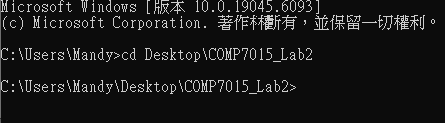
   
4. Launch TensorBoard

   Run the following command to start TensorBoard:
   > `tensorboard --logdir=runs`
   
    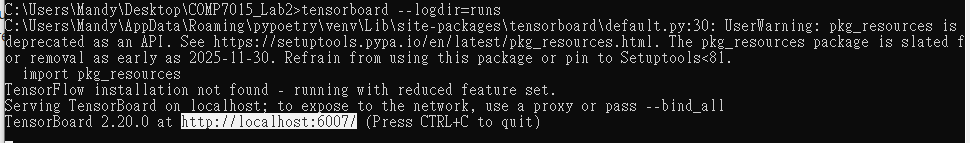
   
5. Open TensorBoard in your browser
   After launching, the terminal will display a URL like:
   

6. Stop the TensorBoard

   When you're done, press `CTRL + C` in the terminal to stop TensorBoard

### Clearing Previous TensorBoard Logs
Before starting a new training session, you may want to delete any existing logs to avoid confusion or overlap in TensorBoard. The following code removes the entire `runs/` directory, which is where `SummaryWriter` stores logs by default.

You can review and select the logs you want to display in TensorBoard.

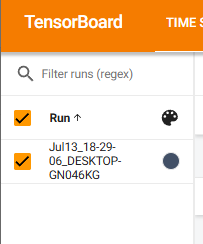

In [16]:
import shutil
import os

log_dir = "runs"

if os.path.exists(log_dir):
    shutil.rmtree(log_dir)  # Deletes all previous logs

## Early stopping by saving the best checkpoints
Train a model with early stopping and checkpoint saving to ensure optimal performance without unnecessary training epochs.

### Why Early Stopping?
Training for only one epoch often results in poor performance. But training for too many epochs can be inefficient and might lead to overfitting. Early stopping offers a smart balance: it monitors the model’s validation accuracy and halts training when performance stops improving.

We also use `torch.save()` to preserve the best-performing model, so we don't lose good progress due to over-training.

In this implementation, we define two key variables:

`patience`: how many epochs to wait for improvement before stopping

`trigger_times`: counter to track how long we've waited without improvement

> Since the Iris Species dataset is quite small, the model tends to converge quickly—so early stopping might be triggered after just a few epochs. You can try increasing the patience value to observe how it affects training duration and model performance.

In [17]:
epochs_num = 100

# variable for checking best point
best_val_acc = 0.0
patience = 15 
trigger_times = 0

for epoch in range(epochs_num):
    model.train() 
    train_loop = tqdm(train_loader, position=0, leave=True)

    step = 0
    running_loss = 0.0
    avg_loss = 0.0
    val_accuracy = 0.0
    
    for (input, label) in train_loop: 
        if torch.cuda.is_available():
            input, label = input.cuda(), label.cuda()
        optimizer.zero_grad()         
        output = model.forward(input) 
        loss = loss_function(output, label) 
        loss.backward()               
        optimizer.step()                 
        running_loss += loss.item()     
        train_loop.set_description(f"Epoch [{epoch+1}/{epochs_num}]") 
        train_loop.set_postfix(loss=loss.item()) 
        writer.add_scalar("Loss/Train_Step", loss.item(), epoch * len(train_loader) + step)
        step += 1
        
    avg_loss = running_loss / len(train_loader)
    writer.add_scalar("Loss/Train_Epoch", avg_loss, epoch)
    
    correct = 0
    total = 0  
    model.eval() 
    val_loop = tqdm(test_loader, desc="Validating", position=0, leave=True)
    
    with torch.no_grad():  
        for inputs, labels in val_loop:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
    
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loop.set_postfix(acc=(100 * correct / total))  

    val_accuracy = 100 * correct / total
    writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)
    writer.flush()

    # Early stopping and checkpoint logic
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        trigger_times = 0
        torch.save(model.state_dict(), "best_model.pth")
        print(f" Saved best model at epoch {epoch+1} with val acc: {val_accuracy:.2f}%")
    else:
        trigger_times += 1
        print(f" No improvement. Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break
    
writer.close()

Validating: 100%|██████████| 1/1 [00:00<00:00, 183.04it/s, acc=43.3]


 Saved best model at epoch 1 with val acc: 43.33%


Validating: 100%|██████████| 1/1 [00:00<00:00, 118.44it/s, acc=50]


 Saved best model at epoch 2 with val acc: 50.00%


Validating: 100%|██████████| 1/1 [00:00<00:00, 100.67it/s, acc=36.7]


 No improvement. Trigger times: 1/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 105.97it/s, acc=53.3]


 Saved best model at epoch 4 with val acc: 53.33%


Validating: 100%|██████████| 1/1 [00:00<00:00, 167.77it/s, acc=36.7]


 No improvement. Trigger times: 1/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 125.83it/s, acc=43.3]


 No improvement. Trigger times: 2/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 125.84it/s, acc=43.3]


 No improvement. Trigger times: 3/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 201.35it/s, acc=50]


 No improvement. Trigger times: 4/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 118.44it/s, acc=50]


 No improvement. Trigger times: 5/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 167.78it/s, acc=60]


 Saved best model at epoch 10 with val acc: 60.00%


Validating: 100%|██████████| 1/1 [00:00<00:00, 167.79it/s, acc=56.7]


 No improvement. Trigger times: 1/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 167.78it/s, acc=53.3]


 No improvement. Trigger times: 2/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 167.80it/s, acc=43.3]


 No improvement. Trigger times: 3/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 183.05it/s, acc=40]


 No improvement. Trigger times: 4/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 201.35it/s, acc=50]


 No improvement. Trigger times: 5/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 183.05it/s, acc=40]


 No improvement. Trigger times: 6/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 183.04it/s, acc=70]


 Saved best model at epoch 17 with val acc: 70.00%


Validating: 100%|██████████| 1/1 [00:00<00:00, 167.79it/s, acc=63.3]


 No improvement. Trigger times: 1/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 183.05it/s, acc=46.7]


 No improvement. Trigger times: 2/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 201.36it/s, acc=43.3]


 No improvement. Trigger times: 3/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 167.80it/s, acc=43.3]


 No improvement. Trigger times: 4/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 167.79it/s, acc=66.7]


 No improvement. Trigger times: 5/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 183.06it/s, acc=76.7]


 Saved best model at epoch 23 with val acc: 76.67%


Validating: 100%|██████████| 1/1 [00:00<00:00, 167.80it/s, acc=56.7]


 No improvement. Trigger times: 1/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 183.06it/s, acc=53.3]


 No improvement. Trigger times: 2/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 167.78it/s, acc=53.3]


 No improvement. Trigger times: 3/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 201.35it/s, acc=50]


 No improvement. Trigger times: 4/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 183.03it/s, acc=70]


 No improvement. Trigger times: 5/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 223.72it/s, acc=50]


 No improvement. Trigger times: 6/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 183.04it/s, acc=63.3]


 No improvement. Trigger times: 7/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 201.35it/s, acc=56.7]


 No improvement. Trigger times: 8/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 201.32it/s, acc=53.3]


 No improvement. Trigger times: 9/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 201.34it/s, acc=76.7]


 No improvement. Trigger times: 10/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 201.32it/s, acc=66.7]


 No improvement. Trigger times: 11/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 201.34it/s, acc=60]


 No improvement. Trigger times: 12/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 183.03it/s, acc=60]


 No improvement. Trigger times: 13/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 223.73it/s, acc=53.3]


 No improvement. Trigger times: 14/15


Validating: 100%|██████████| 1/1 [00:00<00:00, 201.35it/s, acc=63.3]

 No improvement. Trigger times: 15/15
Early stopping triggered.


Go to [http://localhost:6006/](http://localhost:6006/) to check thetraining metrics in the TensorBoard

In [18]:
!tensorboard --logdir=runs --port=6006

2025-08-10 14:22:26.094268: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-10 14:22:26.738877: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
E0810 14:22:28.848156 27896 program.py:300] TensorBoard could not bind to port 6006, it was already in use
ERROR: TensorBoard could not bind to port 6006, it was already in use


## Loading the Best Checkpoint and Testing the MLP Model
After training, we saved the best-performing model using `torch.save()`. Now, we’ll load that checkpoint using `load_state_dict(torch.load(...))` and evaluate the model on the test set to verify its performance.

### Load the Best Model
Before loading the saved checkpoint, we need to recreate the model architecture. This is because `torch.save(model.state_dict())` only saves the model’s weights but not the architecture itself. 

In [19]:
model = IrisMLP() 
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

if torch.cuda.is_available():
    model.cuda()

### Evaluate on the Test Set
We’ll now test the model using the `test_loader` and display the accuracy using a progress bar.

> You can run this evaluation multiple times to check whether the model consistently achieves similar accuracy. Since the model is in evaluation mode and no randomness is introduced during inference, the results should be stable across runs.

In [20]:
correct = 0
total = 0

# wrap the test_loader to the progress bar
val_loop = tqdm(test_loader, desc="Validating", position=0, leave=True)

with torch.no_grad():
    for inputs, labels in val_loop: #use val_loop to trigger update of the progress bar
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        val_loop.set_postfix(acc=(100 * correct / total))  
        
final_accuracy = 100 * correct / total
print(f" Final Test Accuracy: {final_accuracy:.2f}%")

Validating: 100%|██████████| 1/1 [00:00<00:00, 154.88it/s, acc=76.7]

 Final Test Accuracy: 76.67%
